In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Glvq:

    def __init__(self, prototype_per_class):
        self.prototype_per_class = prototype_per_class

    update_prototypes = np.array([])
    prt_labels = np.array([])

    # normalize the data
    def normalization(self, input_data):
        minimum = np.amin(input_data, axis=0)
        maximum = np.amax(input_data, axis=0)
        normalized_data = (input_data - minimum)/(maximum - minimum)
        return normalized_data

    # define prototypes
    def prt(self, input_data, data_labels, prototype_per_class):

        # prototype_labels are
        prototype_labels = np.unique(data_labels)
        prototype_labels = list(prototype_labels) * prototype_per_class

        # prototypes are
        prt_labels = np.expand_dims(prototype_labels, axis=1)
        expand_dimension = np.expand_dims(np.equal(prt_labels, data_labels),
                                          axis=2)

        count = np.count_nonzero(expand_dimension, axis=1)
        proto = np.where(expand_dimension, input_data, 0)
        prototypes = np.sum(proto, axis=1)/count

        self.prt_labels = prototype_labels
        return self.prt_labels, prototypes

    # define euclidean distance
    def euclidean_dist(self, input_data, prototypes):
        expand_dimension = np.expand_dims(input_data, axis=1)
        distance = expand_dimension - prototypes
        distance_square = np.square(distance)
        sum_distance = np.sum(distance_square, axis=2)
        eu_dist = np.sqrt(sum_distance)
        return eu_dist

    # define d_plus
    def distance_plus(self, data_labels, prototype_labels,
                      prototypes, eu_dist):
        expand_dimension = np.expand_dims(prototype_labels, axis=1)
        label_transpose = np.transpose(np.equal(expand_dimension, data_labels))

        # distance of matching prototypes
        plus_dist = np.where(label_transpose, eu_dist, np.inf)
        d_plus = np.min(plus_dist, axis=1)

        # index of minimum distance for best matching prototypes
        w_plus_index = np.argmin(plus_dist, axis=1)
        w_plus = prototypes[w_plus_index]
        return d_plus, w_plus, w_plus_index

    # define d_minus
    def distance_minus(self, data_labels, prototype_labels,
                       prototypes, eu_dist):
        expand_dimension = np.expand_dims(prototype_labels, axis=1)
        label_transpose = np.transpose(np.not_equal(expand_dimension,
                                                    data_labels))

        # distance of non matching prototypes
        minus_dist = np.where(label_transpose, eu_dist, np.inf)
        d_minus = np.min(minus_dist, axis=1)

        # index of minimum distance for non best matching prototypes
        w_minus_index = np.argmin(minus_dist, axis=1)
        w_minus = prototypes[w_minus_index]
        return d_minus, w_minus, w_minus_index

    # define classifier function
    def classifier_function(self, d_plus, d_minus):
        classifier = (d_plus - d_minus) / (d_plus + d_minus)
        return classifier

    # define sigmoid function
    def sigmoid(self, x, beta=10):
        return (1/(1 + np.exp(-beta * x)))

    # define delta_w_plus
    def change_in_w_plus(self, input_data, prototypes, lr, classifier,
                         w_plus, w_plus_index, d_plus, d_minus):

        sai = (2) * (d_minus / (np.square(d_plus + d_minus))) * \
            (self.sigmoid(classifier)) * (1 - self.sigmoid(classifier))

        expand_dimension = np.expand_dims(sai, axis=1)
        change_w_plus = expand_dimension * (input_data - w_plus) * lr

        # index of w_plus
        unique_w_plus_index = np.unique(w_plus_index)
        unique_w_plus_index = np.expand_dims(unique_w_plus_index, axis=1)

        add_row_change_in_w = np.column_stack((w_plus_index, change_w_plus))
        check = np.equal(add_row_change_in_w[:, 0], unique_w_plus_index)
        check = np.expand_dims(check, axis=2)
        check = np.where(check, change_w_plus, 0)
        sum_change_in_w_plus = np.sum(check, axis=1)
        return sum_change_in_w_plus, unique_w_plus_index

    # define delta_w_minus
    def change_in_w_minus(self, input_data, prototypes, lr, classifier,
                          w_minus, w_minus_index, d_plus, d_minus):

        sai = (2) * (d_plus / (np.square(d_plus + d_minus))) * \
            (self.sigmoid(classifier)) * (1 - self.sigmoid(classifier))

        expand_dimension = np.expand_dims(sai, axis=1)
        change_w_minus = (expand_dimension) * (input_data - w_minus) * lr

        # index of w_minus
        unique_w_minus_index = np.unique(w_minus_index)
        unique_w_minus_index = np.expand_dims(unique_w_minus_index, axis=1)

        add_row_change_in_w = np.column_stack((w_minus_index, change_w_minus))
        check = np.equal(add_row_change_in_w[:, 0], unique_w_minus_index)
        check = np.expand_dims(check, axis=2)
        check = np.where(check, change_w_minus, 0)
        sum_change_in_w_minus = np.sum(check, axis=1)
        return sum_change_in_w_minus, unique_w_minus_index

    # plot  data
    def plot(self, input_data, data_labels, prototypes, prototype_labels):
        plt.scatter(input_data[:, 0], input_data[:, 2], c=data_labels,
                    cmap='viridis')
        plt.scatter(prototypes[:, 0], prototypes[:, 2], c=prototype_labels,
                    s=60, marker='D', edgecolor='k')

    # fit function
    def fit(self, input_data, data_labels, learning_rate, epochs):
        normalized_data = self.normalization(input_data)
        prototype_l, prototypes = self.prt(normalized_data, data_labels,
                                           self.prototype_per_class)
        error = np.array([])
        plt.subplots(8, 8)
        for i in range(epochs):
            eu_dist = self.euclidean_dist(normalized_data, prototypes)

            d_plus, w_plus, w_plus_index = self.distance_plus(data_labels,
                                                              prototype_l,
                                                              prototypes,
                                                              eu_dist)

            d_minus, w_minus, w_minus_index = self.distance_minus(data_labels,
                                                                  prototype_l,
                                                                  prototypes,
                                                                  eu_dist)

            classifier = self.classifier_function(d_plus, d_minus)

            sum_change_in_w_plus, unique_w_plus_index = self.change_in_w_plus(
                normalized_data, prototypes, learning_rate, classifier,
                w_plus, w_plus_index,  d_plus, d_minus)
            update_w_p = np.add(np.squeeze(
                prototypes[unique_w_plus_index]), sum_change_in_w_plus)
            np.put_along_axis(prototypes, unique_w_plus_index,
                              update_w_p, axis=0)

            sum_change_in_w_m, unique_w_minus_index = self.change_in_w_minus(
                normalized_data, prototypes, learning_rate, classifier,
                w_minus, w_minus_index, d_plus, d_minus)
            update_w_m = np.subtract(np.squeeze(
                prototypes[unique_w_minus_index]), sum_change_in_w_m)
            np.put_along_axis(
                prototypes, unique_w_minus_index, update_w_m, axis=0)

            err = np.sum(self.sigmoid(classifier), axis=0)
            change_in_error = 0

            if (i == 0):
                change_in_error = 0

            else:
                change_in_error = error[-1] - err

            error = np.append(error, err)
            print("Epoch : {}, Error : {} Error change : {}".format(
                i + 1, err, change_in_error))

            plt.subplot(1, 2, 1)
            self.plot(normalized_data, data_labels, prototypes, prototype_l)
            plt.subplot(1, 2, 2)
            plt.plot(np.arange(i + 1), error, marker="d")
            plt.pause(0.5)
        plt.show()
        accuracy = np.count_nonzero(d_plus < d_minus)
        acc = accuracy / len(d_plus) * 100
        print("accuracy = {}".format(acc))
        self.update_prototypes = prototypes
        return self.update_prototypes

    # data predict
    def predict(self, input_value):
        input_value = self.normalization(input_value)
        prototypes = self.update_prototypes
        eu_dist = self.euclidean_dist(input_value, prototypes)
        m_d = np.min(eu_dist, axis=1)
        expand_dims = np.expand_dims(m_d, axis=1)
        ylabel = np.where(np.equal(expand_dims, eu_dist),
                          self.prt_labels, np.inf)
        ylabel = np.min(ylabel, axis=1)
        print(ylabel)
        return ylabel

Epoch : 1, Error : 10.991937313276303 Error change : 0


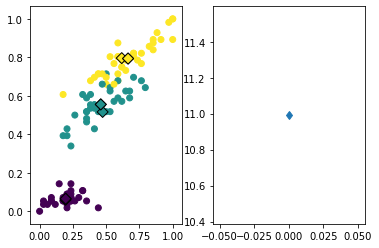

Epoch : 2, Error : 10.041276269226133 Error change : 0.9506610440501699


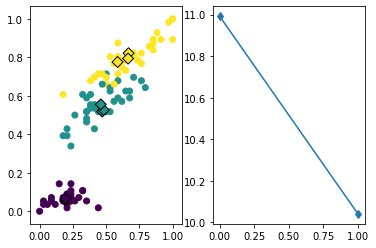

accuracy = 92.38095238095238
[1. 0. 2. 1. 1. 0. 1. 2. 1. 1. 2. 0. 0. 0. 0. 2. 2. 1. 1. 2. 0. 2. 0. 2.
 2. 2. 2. 2. 0. 0. 0. 0. 1. 0. 0. 2. 1. 0. 0. 0. 2. 1. 2. 0. 0.]


In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
#from glvq_numpy import Glvq

prototype_per_class = 3
input_data = load_iris().data
data_label = load_iris().target
epochs = 2
learning_rate = 0.1

clf = Glvq(prototype_per_class)

X_train, X_test, y_train, y_test = train_test_split(input_data,
                                                    data_label,
                                                    test_size=0.3,
                                                    random_state=42)

clf.fit(X_train, y_train, learning_rate, epochs)

y_predict = clf.predict(X_test)